**Note to self: No Mean 0 and Standard Deviation 1 as of now**. 


In [1]:
!nvidia-smi

Thu Apr 23 08:48:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
!sudo apt-get install tree

In [5]:
!tree --dirsfirst --filelimit 20 imagenet-5-categories

imagenet-5-categories
├── test [250 entries exceeds filelimit, not opening dir]
├── train [1250 entries exceeds filelimit, not opening dir]
└── README.md

2 directories, 1 file


In [0]:
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np

np.random.seed(0)

In [0]:
train_images = list(paths.list_images("imagenet-5-categories/train"))

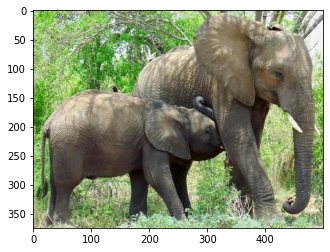

In [8]:
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]
image = plt.imread(sample_training_image)
plt.imshow(image)
plt.show()

In [0]:
# Reference: https://github.com/sthalles/SimCLR/blob/master/data_aug/gaussian_blur.py
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size=int(0.1 * 150), min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = sample.numpy()
        sample = sample.squeeze(0)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return tf.convert_to_tensor(np.expand_dims(sample, 0))

In [0]:
class CustomAugment(object):
    def __call__(self, sample):
        if np.random.random_sample() >= 0.5:
            h = np.random.choice(tf.shape(sample)[1].numpy(), 1) 
            w = np.random.choice(tf.shape(sample)[2].numpy(), 1)
            sample = tf.image.random_crop(sample, [1, int(h), int(w), 3])
            sample = tf.image.resize(sample, size=[224, 224])
        
        if np.random.random_sample() >= 0.5:
            sample = tf.image.flip_left_right(sample)
        
        if np.random.random_sample() >= 0.6:
            sample = self._color_jitter(sample)

        # if np.random.random_sample() >= 0.2:
        #     sample = self._gray_scale(sample)

        return sample

    def _color_jitter(self, sample):
        jitter = np.random.choice(["brightness", "contrast", "saturation", "hue"])
        
        if jitter == "brightness":
            sample = tf.image.random_brightness(sample, max_delta=0.005)
        elif jitter == "contrast": 
            sample = tf.image.random_contrast(sample, lower=0.02, upper=0.05)
        elif jitter == "saturation":
            sample = tf.image.random_saturation(sample, lower=0.001, upper=0.005)
        else:
            sample = tf.image.random_hue(sample, max_delta=0.005)

        return sample

    def _gray_scale(self, sample):
        sample = tf.image.rgb_to_grayscale(sample)
        new_sample = cv2.cvtColor(sample.numpy().squeeze(0), cv2.COLOR_GRAY2RGB)
        new_sample = tf.convert_to_tensor(np.expand_dims(new_sample, 0))
        return new_sample

In [0]:
data_augmentation = keras.Sequential([
    layers.Lambda(CustomAugment()),
    # layers.Lambda(GaussianBlur())
])

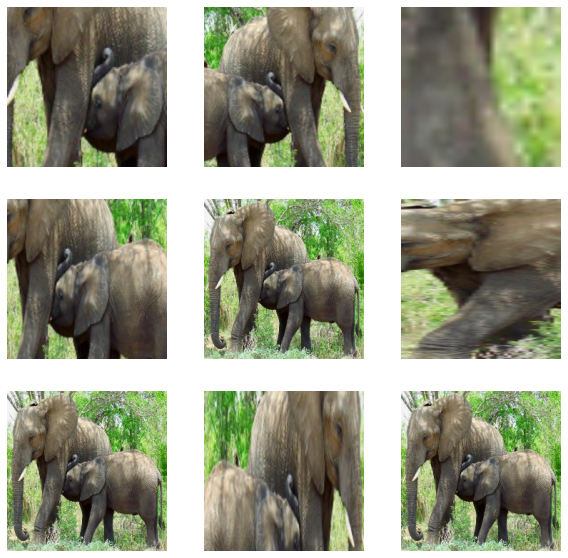

In [52]:
image = plt.imread(sample_training_image)
image = cv2.resize(image, (224, 224))
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')

In [0]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
train_ds = tf.data.Dataset.from_tensor_slices(train_images)

In [0]:
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [0]:
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(250)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
def display_one_flower(image, subplot):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    return subplot+1

In [0]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images in dataset:
        numpy_images = images.numpy()
        break;  
    return numpy_images

In [0]:
def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        subplot = display_one_flower(image, subplot)
        if i >= 8:
            break;
                
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

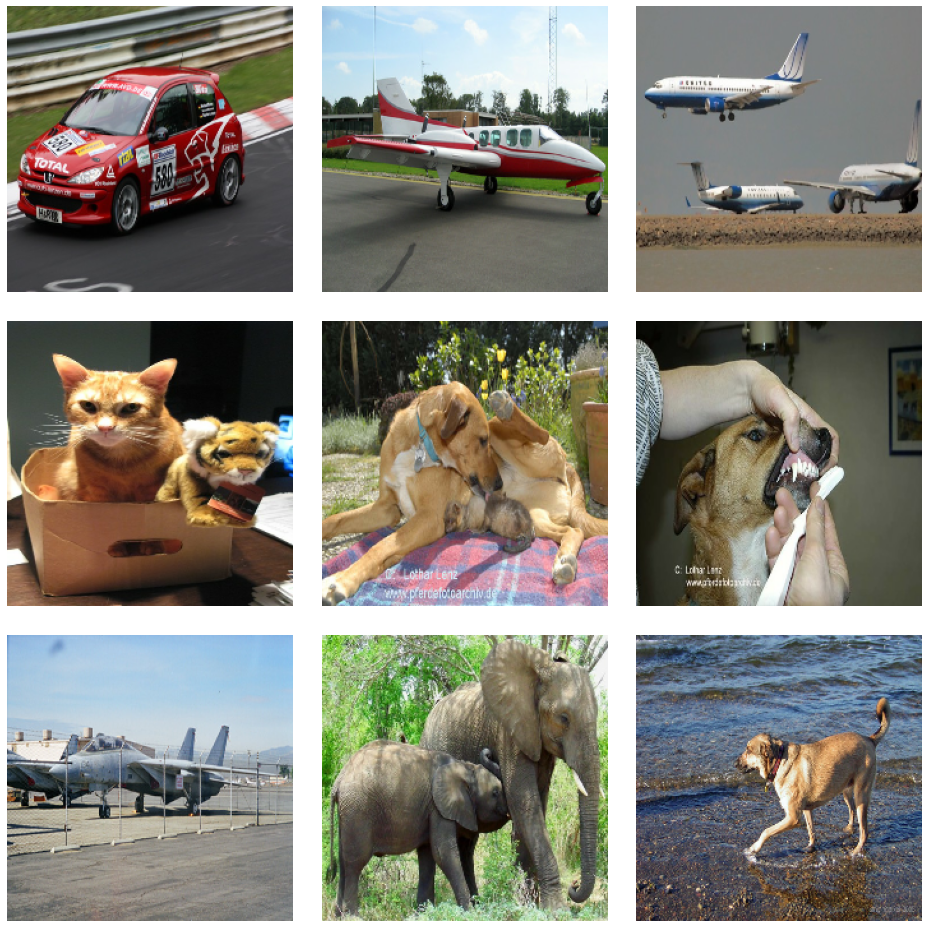

In [59]:
display_9_images_from_dataset(train_ds)

In [60]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
inputs = layers.Input((224, 224, 3))
h = base_model(inputs, training=True)
h = keras.layers.GlobalAveragePooling2D()(h)

projection_1 = keras.layers.Dense(512, activation="relu")(h)
projection_2 = keras.layers.Dense(256)(projection_1)

resnet_simclr = keras.Model(inputs, projection_2)

resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
Total params: 24,768,128
Trainable params: 24,715,008
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
def nt_xentloss(a, b):
    tau = 0.1

    a_norm = tf.reshape(tf.norm(a, ord="fro", axis=(0, 1)), (-1, 1))
    a_cap = tf.divide(a, a_norm)
    b_norm = tf.reshape(tf.norm(b, ord="fro", axis=(0, 1)), (-1, 1))
    b_cap = tf.divide(b, b_norm)

    a_cap_b_cap = tf.concat([a_cap, b_cap],0)
    a_cap_b_cap_transpose = tf.transpose(a_cap_b_cap)
    b_cap_a_cap = tf.concat([b_cap,a_cap], 0)

    sim = tf.matmul(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = tf.divide(sim, tau)
    exp_sim_by_tau = tf.exp(sim_by_tau)

    sum_of_rows = tf.reduce_sum(exp_sim_by_tau, axis=1)
    exp_sim_by_tau_diag = tf.linalg.diag(exp_sim_by_tau)
    
    cs = tf.keras.metrics.CosineSimilarity()
    cs.reset_states()
    cs.update_state([a_cap_b_cap], [b_cap_a_cap])
    numerators = tf.exp(tf.divide(cs.result(), tau))
    
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = tf.divide(numerators, denominators)
    neglog_num_by_den = - tf.math.log(num_by_den)
    
    return tf.reduce_mean(neglog_num_by_den)

In [48]:
for image_batch in train_ds.take(1):
    pass
image_batch[1].shape

TensorShape([224, 224, 3])

In [0]:
image_batch_expanded = tf.expand_dims(image_batch[1], 0)
image_batch_expanded = data_augmentation(image_batch_expanded)
representation_1 = resnet_simclr(image_batch_expanded)

In [0]:
image_batch_expanded = tf.expand_dims(image_batch[1], 0)
image_batch_expanded = data_augmentation(image_batch_expanded)
representation_2 = resnet_simclr(image_batch_expanded)

In [31]:
representation_1.shape, representation_2.shape

(TensorShape([1, 256]), TensorShape([1, 256]))

In [32]:
nt_xentloss(representation_1, representation_2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.35925007>

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [63]:
total_train_loss = []

for epoch in range(100):
    for image_batch in train_ds:
        a = data_augmentation(image_batch)
        b = data_augmentation(image_batch)

        with tf.GradientTape() as tape:
            representation_a = resnet_simclr(a)
            representation_b = resnet_simclr(b)

            loss_value = nt_xentloss(representation_a, representation_b)
            print("epoch: {} loss {}".format(epoch + 1, loss_value.numpy()))
        
        # Get gradients of loss wrt the *trainable* weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        total_train_loss.append(loss_value.numpy())

ResourceExhaustedError: ignored